In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPUs


In [4]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))

In [5]:
def Idtotext(id_list,padding = False):
  ans = []
  for id in id_list:
    ch = id2word_dict[str(id)]
    if ch == '<PAD>' and not padding:
      break
    if ch == '<RARE>' and not padding:
      continue
    ans.append(ch)
  return ' '.join(ans)

### Hyperparameters

In [7]:
image_height = 64
image_width= 64
image_channel = 3

batch_size = 64
num_epochs = 100  # Just for the sake of demonstration
total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4
weight_decay = 1e-3
ema = 0.999

img_size = 64
img_channels = 3
clip_min = -1.0
clip_max = 1.0
max_length = 25

first_conv_channels = 32
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
has_cross_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks
text_embedding_dims = 768

### Dataset

In [9]:
from transformers import CLIPTokenizer, TFCLIPTextModel
data_path = './dataset'
model_name = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_encoder = TFCLIPTextModel.from_pretrained(model_name)

In [10]:
df_train = pd.read_pickle(data_path + '/text2ImgData.pkl')
df_train['Texts'] = df_train['Captions'].apply(lambda x: [Idtotext(id_list) for id_list in x])
df_train['inputs'] = df_train['Texts'].apply(lambda x: tokenizer(x,padding="max_length",truncation=True,max_length=max_length,return_tensors="tf"))
df_train['attention_mask'] = df_train['Texts'].apply(lambda x: tokenizer(x,padding="max_length",truncation=True,max_length=max_length,return_tensors="tf")['attention_mask'])
df_train['last_hidden_state'] = df_train['inputs'].apply(lambda x: text_encoder(**x).last_hidden_state)
df_train = df_train.drop(columns=['inputs'])

In [14]:
def map_train(image_path, attention_mask, embedding):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])

    # Center Cropping
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)
    img = tf.image.crop_to_bounding_box(img, (height - crop_size) // 2, (width - crop_size) // 2, crop_size, crop_size)

    # Random Cropping
    if tf.random.uniform([]) < 0.5:
        crop_size = tf.random.uniform([], minval=tf.cast(0.8 * tf.cast(crop_size, tf.float32), tf.int32), maxval=crop_size, dtype=tf.int32)
        img = tf.image.random_crop(img, size=[crop_size, crop_size, 3])

    # Random Flip Left and Right
    if tf.random.uniform([]) < 0.5:
        img = tf.image.flip_left_right(img)

    img = tf.image.resize(img, size=[image_height, image_width], antialias=True)
    img = img * 2 - 1
    img = tf.clip_by_value(img, clip_min, clip_max)
    img.set_shape([image_height, image_width, image_channel])

    embedding = tf.cast(embedding, tf.float32)
    attention_mask = tf.cast(attention_mask, tf.float32)

    return img, embedding, attention_mask

def train_dataset_generator(embedding_array, attention_mask_array, image_path_array, batch_size):
    embedding_list = []
    attention_mask_list = []
    image_path_list = []

    for embeddings, attention_masks, image_path in zip(embedding_array, attention_mask_array, image_path_array):
        for i in range(len(embeddings)):
            embedding_list.append(embeddings[i])
            attention_mask_list.append(attention_masks[i])
            image_path_list.append(image_path)


    dataset = tf.data.Dataset.from_tensor_slices((image_path_list, attention_mask_list, embedding_list))
    dataset = dataset.map(map_train, tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(embedding_list))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

dataset_train = train_dataset_generator(df_train['last_hidden_state'].values, df_train['attention_mask'].values, df_train['ImagePath'].values, batch_size)
print(f'There are {len(dataset_train) * batch_size:d} samples in training data.')
del df_train

## Gaussian diffusion utilities

In [15]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

### U-Net

In [16]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )

class CrossAttentionBlock(layers.Layer):
    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        super().__init__(**kwargs)

        self.norm_q = tfa.layers.GroupNormalization(groups=groups)
        self.norm_kv = tfa.layers.GroupNormalization(groups=groups)

        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs_q, inputs_kv, attention_mask=None):
        batch_size = tf.shape(inputs_q)[0]
        height = tf.shape(inputs_q)[1]
        width = tf.shape(inputs_q)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        q = self.query(self.norm_q(inputs_q))  
        kv = self.norm_kv(inputs_kv)  
        k = self.key(kv)  
        v = self.value(kv)  

        q_flatten = tf.reshape(q, [batch_size, height * width, self.units])
        attn_score = tf.einsum("blc, bkc->blk", q_flatten, k) * scale

        if attention_mask is not None:
            attention_mask = tf.reshape(attention_mask, [batch_size, 1, max_length])
            attn_score = attn_score + (1.0 - attention_mask) * -1e9

        attn_score = tf.nn.softmax(attn_score, axis=-1)

        proj = tf.einsum("blk, bkc->blc", attn_score, v)
        proj = tf.reshape(proj, [batch_size, height, width, self.units])
        proj = self.proj(proj)
        
        return inputs_q + proj


class AttentionBlock(layers.Layer):
    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = tfa.layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1, kernel_initializer=kernel_init(1.0))(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[:, None, None, :]

        x = tfa.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0))(x)

        x = layers.Add()([x, temb])
        x = tfa.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Conv2D(width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0))(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = layers.Conv2D(width, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_init(1.0),)(x)
        return x
    
    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0))(x)
        return x

    return apply


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(units, activation=activation_fn, kernel_initializer=kernel_init(1.0))(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    has_cross_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)


    raw_text_hidden_states = layers.Input(shape = (max_length, text_embedding_dims))
    text_hidden_states = layers.LayerNormalization()(raw_text_hidden_states)
    text_hidden_states = layers.Dense(text_embedding_dims, activation=activation_fn, kernel_initializer=kernel_init(1.0))(text_hidden_states)
    text_hidden_states = layers.Dropout(0.1)(text_hidden_states)
    text_hidden_states = layers.Dense(text_embedding_dims, activation=activation_fn, kernel_initializer=kernel_init(1.0))(text_hidden_states)
    text_hidden_states = layers.Dropout(0.1)(text_hidden_states)
    text_hidden_states = text_hidden_states + raw_text_hidden_states
    attention_mask = layers.Input(shape = (max_length))


    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            if has_cross_attention[i]:
                x = CrossAttentionBlock(widths[i], groups=norm_groups)(x, text_hidden_states, attention_mask)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    x = AttentionBlock(widths[-1])(x)
    x = CrossAttentionBlock(widths[-1])(x, text_hidden_states, attention_mask)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            if has_cross_attention[i]:
                x = CrossAttentionBlock(widths[i], groups=norm_groups)(x, text_hidden_states, attention_mask)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = tfa.layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input, raw_text_hidden_states, attention_mask], x, name="unet")

### Diffusion model

In [17]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, x):
        images, text_hidden_states, attention_masks = x
        batch_size = tf.shape(images)[0]
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            images_t = self.gdf_util.q_sample(images, t, noise)
            pred_noise = self.network([images_t, t, text_hidden_states, attention_masks], training=True)
            loss = self.loss(noise, pred_noise)

        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        return {"loss": loss}

    def generate_images(self, text_hidden_states, attention_masks):
        num_images = text_hidden_states.shape[0]
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt, text_hidden_states, attention_masks], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        
        samples = (
            tf.clip_by_value(samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        ) 
        return samples

    def plot_images(
        self, text_hidden_states, attention_masks, num_rows=1
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(text_hidden_states, attention_masks)

        num_cols = text_hidden_states.shape[0] // num_rows
        figsize=(num_cols * 2.0, num_rows * 2.0)
        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()

In [18]:
# Build the unet model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    has_cross_attention=has_cross_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    has_cross_attention=has_cross_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

In [19]:
# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
)

# Checkpoints
checkpoint_path = f"./chechpoints/tf_checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
)


# Train the model
# model.fit(
#     dataset_train,
#     epochs=num_epochs,
#     batch_size=batch_size,
#     callbacks=[checkpoint_callback]
# )

### Testing

In [20]:
model.load_weights(checkpoint_path)

In [21]:
from transformers import CLIPTokenizer, TFCLIPTextModel

model_name = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_encoder = TFCLIPTextModel.from_pretrained(model_name)

In [22]:
df_test = pd.read_pickle(data_path + '/testData.pkl')
df_test['Texts'] = df_test['Captions'].apply(lambda x: [Idtotext(x)])
df_test['inputs'] = df_test['Texts'].apply(lambda x: tokenizer(x,padding="max_length",truncation=True,max_length=max_length,return_tensors="tf"))
df_test['attention_mask'] = df_test['Texts'].apply(lambda x: tokenizer(x,padding="max_length",truncation=True,max_length=max_length,return_tensors="tf")['attention_mask'])
df_test['last_hidden_state'] = df_test['inputs'].apply(lambda x: text_encoder(**x).last_hidden_state)
df_test= df_test.drop(columns=['inputs'])

In [26]:
def map_test(attention_mask, embedding, id):
    attention_mask = tf.cast(attention_mask, tf.float32)
    embedding = tf.cast(embedding, tf.float32)
    return attention_mask[0], embedding[0], id

def testing_dataset_generator(attention_mask_array, embeddings_array, ids_array, batch_size):
    attention_mask_list = [mask for mask in attention_mask_array]
    embeddings_list = [emb for emb in embeddings_array]
    ids_list = [id for id in ids_array]
    dataset = tf.data.Dataset.from_tensor_slices((attention_mask_list, embeddings_list, ids_list))
    dataset = dataset.map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    return dataset

batch_size *= 4
testing_dataset = testing_dataset_generator(df_test['attention_mask'].values, df_test['last_hidden_state'].values, df_test['ID'].values, batch_size)

In [27]:
test_attn_mask = []
test_text_emb = []
for i in range(0, 12):
    print(df_test['Texts'].values[i])
    test_attn_mask.append(df_test['attention_mask'].values[i][0])
    test_text_emb.append(df_test['last_hidden_state'].values[i][0])
test_attn_mask = tf.cast(test_attn_mask, tf.float32)
test_text_emb = tf.cast(test_text_emb, tf.float32)

['this white and purple flower has fragile petals and soft stamens']
['this flower has four large wide pink petals with white centers and vein like markings']
['a flower with broad white and pink ribbed petals and yellow stamen']
['one prominet pistil with alarger stigam and many stamens with anthers']
['leaves are green in color petals are light pink in color']
['this flower is bright pink with overlapping petals and a lime green pistil']
['this flower is white and yellow in color with petals that are multi colored']
['this flower has 4 leaves three are purple and yellow with lines and one is solid purple']
['the pretty flower has dark and white petals on it']
['this flower has petals that are white with yellow stamen']
['this flower is trumpet shaped with a light pink petal and green sepal']
['this flower has a few bright pink petals that turn more white in the center']


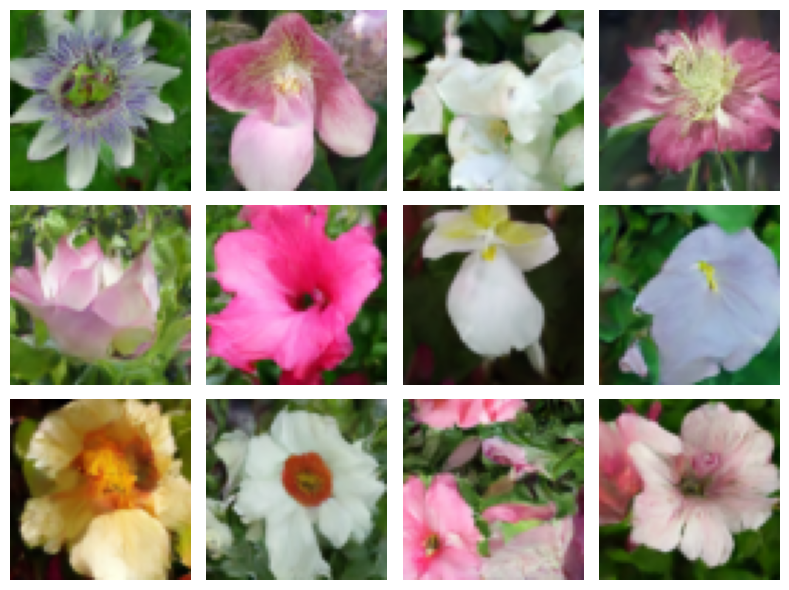

In [28]:
model.plot_images(test_text_emb, test_attn_mask, 3)

In [29]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [30]:
num_test = len(df_test['ID'].values)
iter_test = int(num_test / batch_size)

In [31]:
def inference(dataset):    
    step = 0
    start = time.time()
    for attention_masks, embeddings, ids in dataset:
        if step > iter_test:
            break
        step_start = time.time()
        generate_image = model.generate_images(embeddings, attention_masks)
        step += 1
        for i in range(batch_size):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(ids[i]), generate_image[i])
        print(f"Finish inference {step} / {iter_test + 1} in {time.time() - step_start:.2f} sec.")   
    print('Time for inference is {:.2f} sec in total'.format(time.time()-start))

In [34]:
inference(testing_dataset)

Finish inference 1 / 4 in 265.05 sec.
Finish inference 2 / 4 in 261.52 sec.
Finish inference 3 / 4 in 262.22 sec.
Finish inference 4 / 4 in 261.75 sec.
Time for inference is 1050.57 sec in total


### Inception Score & Cosine Similarity

python ./inception_score.py /home/sean/DL2024/Cup3/2024-datalab-cup3-reverse-image-caption/inference/demo /home/sean/DL2024/Cup3/2024-datalab-cup3-reverse-image-caption/score.csv 9

In [35]:
import os
import pandas as pd
import numpy as np

score_file = './score.csv'
if os.path.exists(score_file):
    df_score = pd.read_csv(score_file)
    mean_score = np.mean(df_score['score'].values)
    print(f'Mean Score: {mean_score:f}')
else:
    print('Evaluation Failed!')

Mean Score: 0.457494
